In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.use_jedi = False

In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from adjustText import adjust_text

from scipy.stats import ks_2samp, ttest_ind
from statsmodels.stats.multitest import multipletests

import scvi
from scvi.model import CondSCVI, DestVI

import umap
import torch
from torch.distributions import Gamma
import gseapy

import base64
from io import BytesIO

from utils import *
import hotspot


%matplotlib inline

# import data and collide cell-types

In [3]:
sc_adata = sc.read_h5ad("scRNA-LN-compressed.h5ad")

In [4]:
sc_adata.obs["broad_cell_types"].value_counts()

B cells          8359
CD8 T cells      3268
CD4 T cells      2043
Tregs             390
Migratory DCs     299
Macrophages       105
cDC1s             100
NK cells           93
GD T cells         88
cDC2s              87
Monocytes          79
pDCs               78
Name: broad_cell_types, dtype: int64

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.umap(
    sc_adata, 
    color="broad_cell_types",
    frameon=True,
    title="",
    legend_loc="on data",
    legend_fontsize="x-large",
    ax=ax, size=10, show=False,
)
plt.tight_layout()
plt.savefig("figures/UMAP_scRNA.pdf", dpi=DPI)

In [6]:
sc_adata.obs["broad_cell_types"].value_counts().sum()

14989

## Filter some genes on scRNA

In [7]:
# let us filter some genes
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=G,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


## get intersection with spatial

In [8]:
st_adata = sc.read_h5ad("ST-LN-compressed.h5ad")

In [9]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

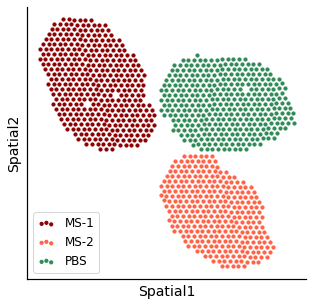

In [10]:
mapping_ln = {"TC": "MS-1", 
              "BD": "MS-2",
              "TD": "PBS"}
st_adata.obs["lymph_node"] = [mapping_ln[x] for x in st_adata.obs["LN"]]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
color_list = ["darkred", "tomato", "seagreen"]
name_list = ["MS-1", "MS-2", "PBS"]
for i, value in enumerate(["TC", "BD", "TD"]):
    mask = st_adata.obs["LN"] == value
    ax.scatter(st_adata.obsm["location"][mask, 0], st_adata.obsm["location"][mask, 1], 
               c=color_list[i], label=name_list[i], s=10)
ax.legend()
prettify_axis(ax, False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Spatial1")
ax.set_ylabel("Spatial2")
plt.savefig("figures/spatial.pdf", dpi=DPI)

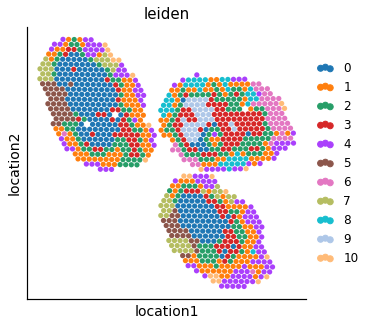

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sc.pl.embedding(st_adata, basis="location", color="leiden", ax=ax, show=False)
plt.savefig("leiden.pdf", dpi=DPI)

In [11]:
st_adata.obs["LN"].value_counts()

TC    400
TD    369
BD    323
Name: LN, dtype: int64

## fit scRNA-seq model

In [12]:
scvi.data.setup_anndata(sc_adata, layer="counts", labels_key="broad_cell_types")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["broad_cell_types"]                                     
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 14989 cells, 1888 vars, 1 batches,
         12 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [13]:
train = False
if train:
    # train the conditional VAE
    sc_model = CondSCVI(sc_adata, weight_obs=True)
    sc_model.train(max_epochs=250)
    sc_model.history["elbo_train"].plot()
    sc_model.save("sc_model", overwrite=True)
else:
    sc_model = CondSCVI.load("CondSCVI", sc_adata, use_gpu=True)

INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 14989 cells, 1888 vars, 1 batches,
         12 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [14]:
sc_adata.obsm["X_CondSCVI"] = sc_model.get_latent_representation()

## Deconvolution

In [15]:
st_adata.layers["counts"] = st_adata.X.copy()

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

In [16]:
# get dataset ready
scvi.data.setup_anndata(st_adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1092 cells, 1888 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [17]:
# add here number of cell type
train_st = False
if train_st:
    st_model = DestVI.from_rna_model(st_adata, sc_model, vamp_prior_p=100)
    st_model.train(max_epochs=2500, plan_kwargs={"lr":0.005})
    st_model.history["elbo_train"].plot()
    st_model.save("st_model", overwrite=True)
else:
    st_model = DestVI.load("st_model", st_adata)

INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'ind_x']                                                                            
INFO     Successfully registered anndata object containing 1092 cells, 1888 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [18]:
st_adata.obsm["proportions"] = st_model.get_proportions()
gamma = st_model.get_gamma(return_numpy=True)

## Statistics on proportions

### Run hotspot to detect more spatially variable cell types

In [19]:
loc = pd.DataFrame(data=st_adata.obsm["location"], index=st_adata.obs.index)
hs = hotspot.Hotspot(st_adata.obsm["proportions"].T, model='none', latent=loc,)

hs.create_knn_graph(
    weighted_graph=True, n_neighbors=50,
)

hs_results = hs.compute_autocorrelations(jobs=4)

100%|██████████| 12/12 [00:00<00:00, 12.64it/s]


##  Show proportion for every cell type spatially and find characteristic proportions

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/ipykernel/__main__.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


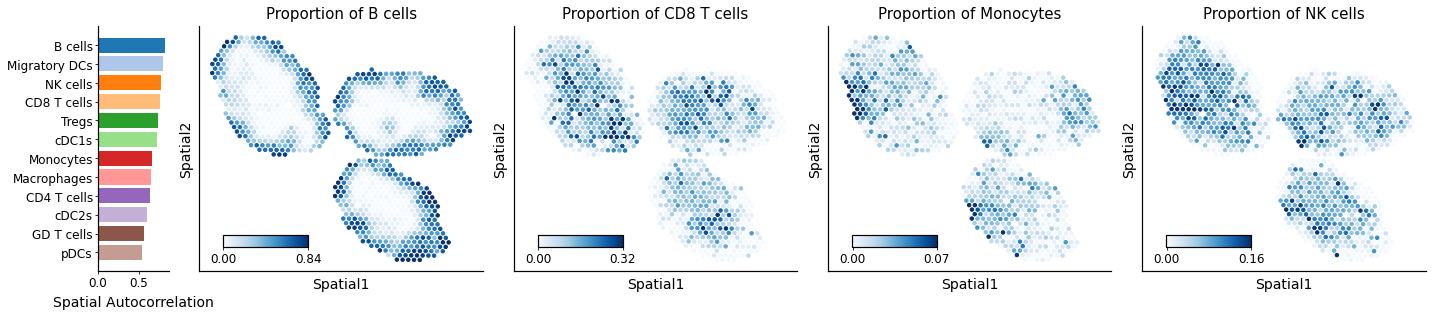

In [21]:
# selected cell type for paper
fig, axes = plt.subplots(1, 5, figsize=(20, 4.5), gridspec_kw={'width_ratios': [0.25, 1, 1, 1, 1]})
ct_list = [None, "B cells", "CD8 T cells", "Monocytes", "NK cells"]
prettify_axis(axes[0])
bar_data = hs_results.sort_values("C", ascending=True)
axes[0].barh(np.arange(bar_data.shape[0]), bar_data["C"].values, color=sns.color_palette("tab20")[0:bar_data.shape[0]][::-1])
axes[0].set_yticks(np.arange(bar_data.shape[0]))
axes[0].set_yticklabels( bar_data.index.values)
axes[0].set_xlabel("Spatial Autocorrelation")

for i in range(1, 5):
    prettify_axis(axes[i], False)
    data = st_adata.obsm["proportions"][ct_list[i]]
    vmax = np.quantile(data, 0.98)
    scplot = axes[i].scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
            c=data, s=12, cmap="Blues", vmax=vmax)
    
    a, b = np.quantile(data, 0.05),np.quantile(data, 0.98)
    ta, tb = ["{:0.2f}".format(x) for x in (a, b)]
    cax = inset_axes(axes[i], width="30%", height="5%", loc=3, borderpad=2) 
    cbar = plt.colorbar(scplot, cax=cax, orientation="horizontal")
    cbar.set_ticks([a, b])
    cbar.set_ticklabels([ta, tb])
    axes[i].set_title(F"Proportion of {ct_list[i]}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("Spatial1")
    axes[i].set_ylabel("Spatial2")
plt.tight_layout()
plt.savefig("figures/proportions.pdf", dpi=DPI)

In [22]:
# all cell types for supplements
# selected cell type for paper
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
ct_list = st_adata.obsm["proportions"].columns
for i in range(3):
    for j in range(4):
        prettify_axis(axes[i, j], False)
        data = st_adata.obsm["proportions"][ct_list[i*4 + j]]
        vmax = np.quantile(data, 0.99)
        scplot = axes[i, j].scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
            c=data, s=12, cmap="Blues", vmax=vmax)
        plt.colorbar(scplot, ax=axes[i, j])
        axes[i, j].set_title(F"Proportion of {ct_list[i*4+j]}")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_xlabel("Spatial1")
        axes[i, j].set_ylabel("Spatial2")
plt.tight_layout()
plt.savefig("figures/proportions_supp.pdf", dpi=DPI)

100%|██████████| 100/100 [00:00<00:00, 14937.51it/s]


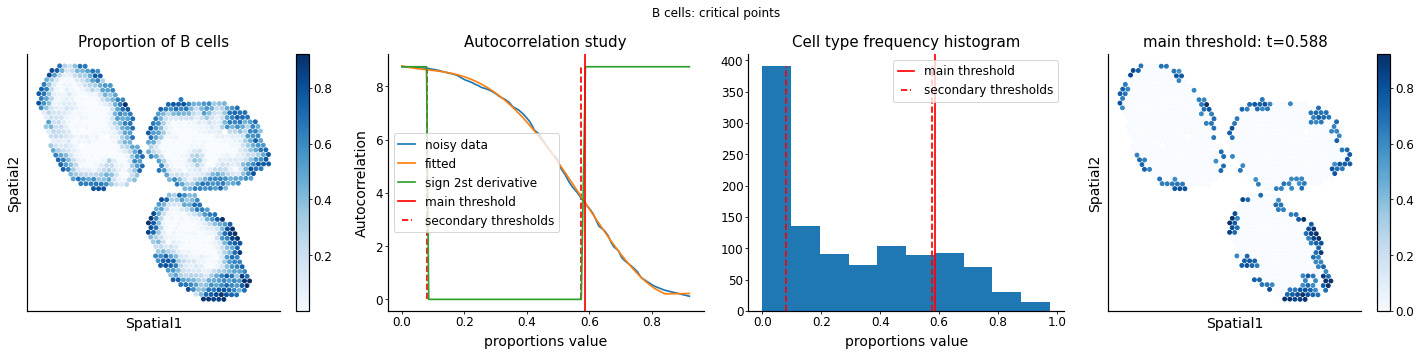

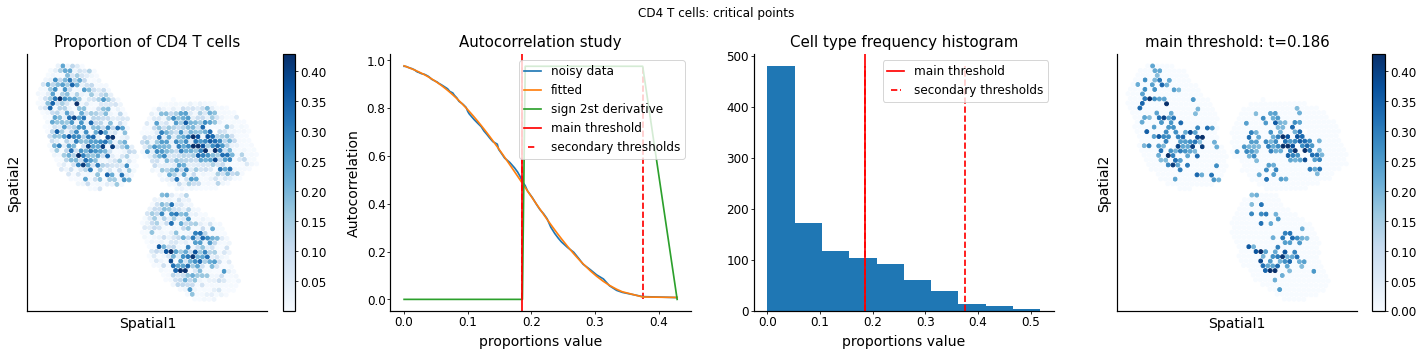

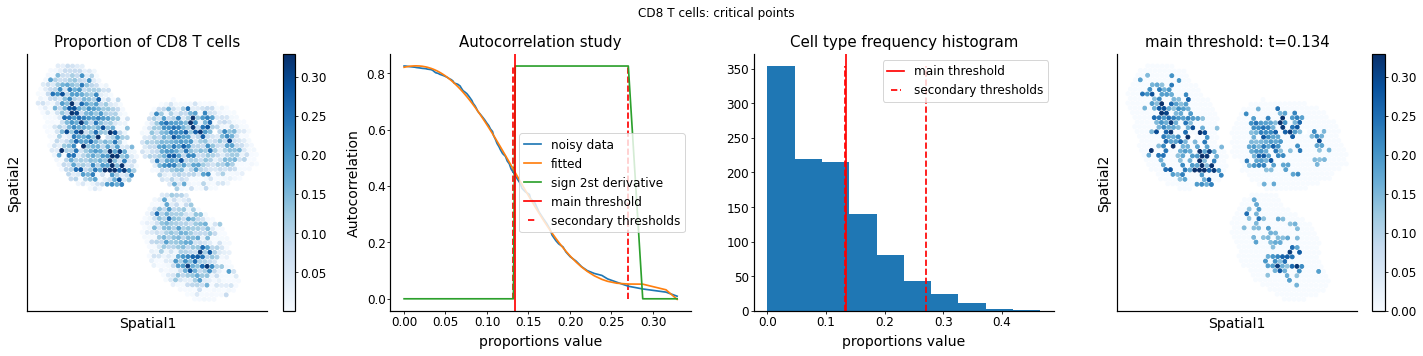

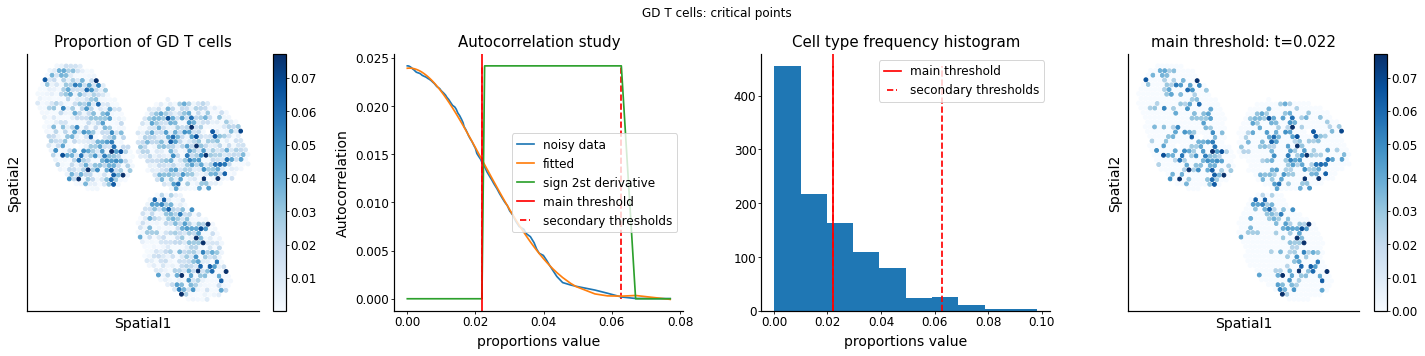

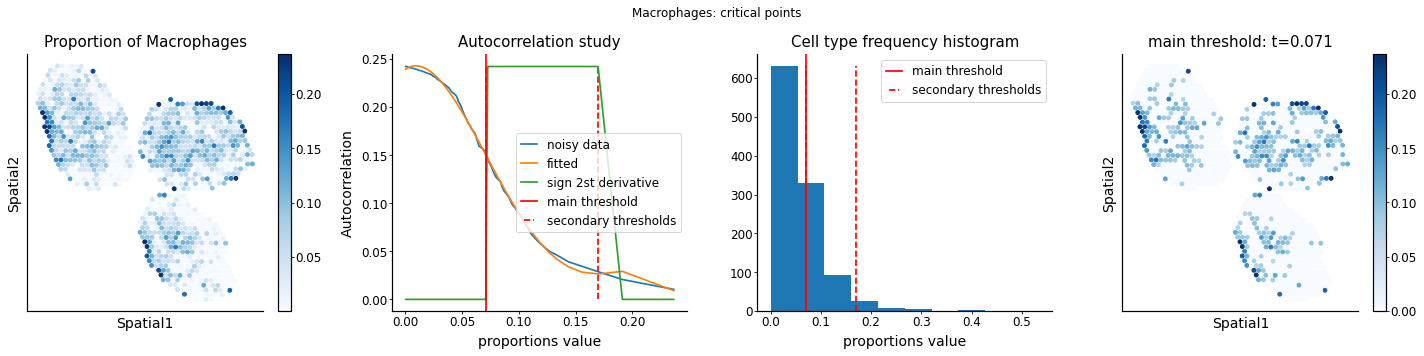

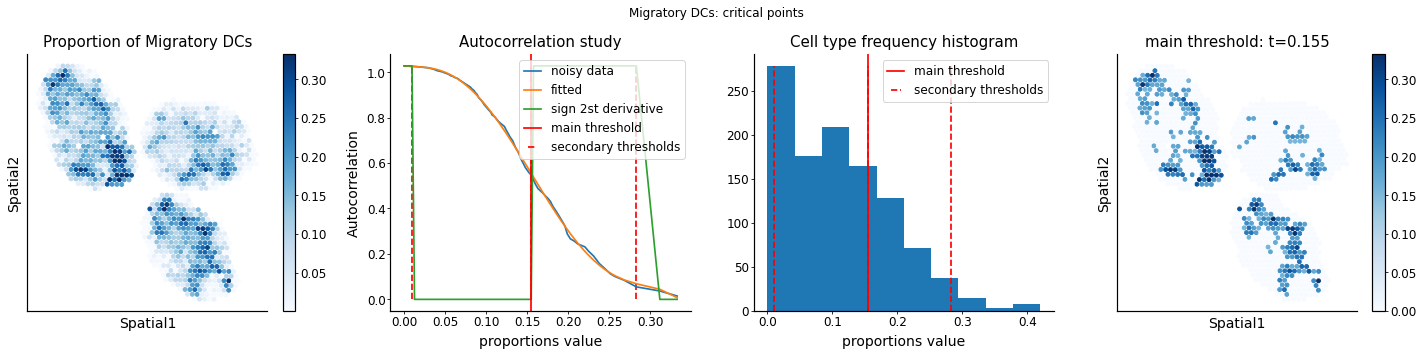

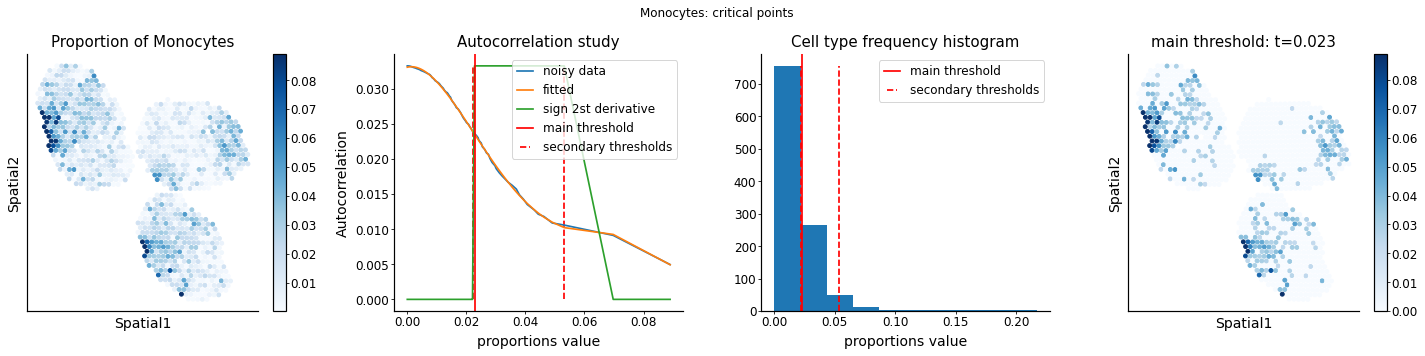

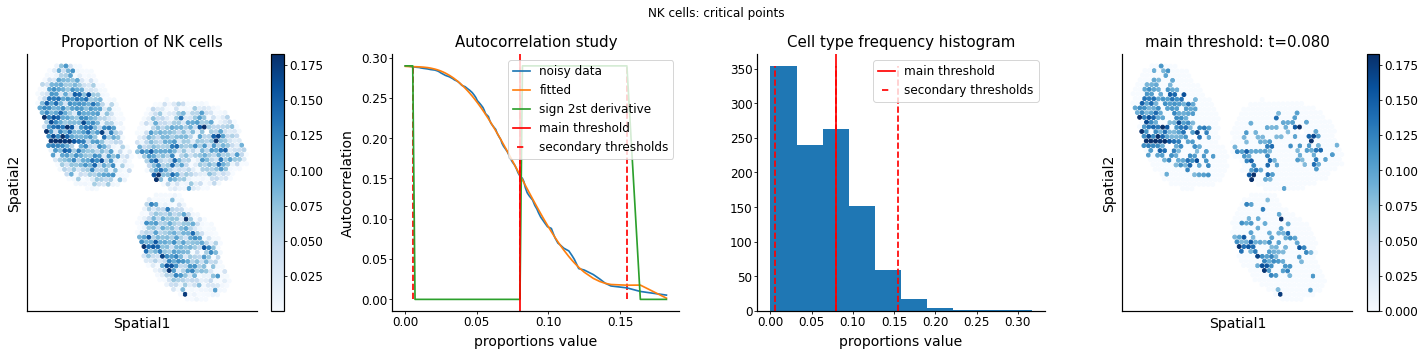

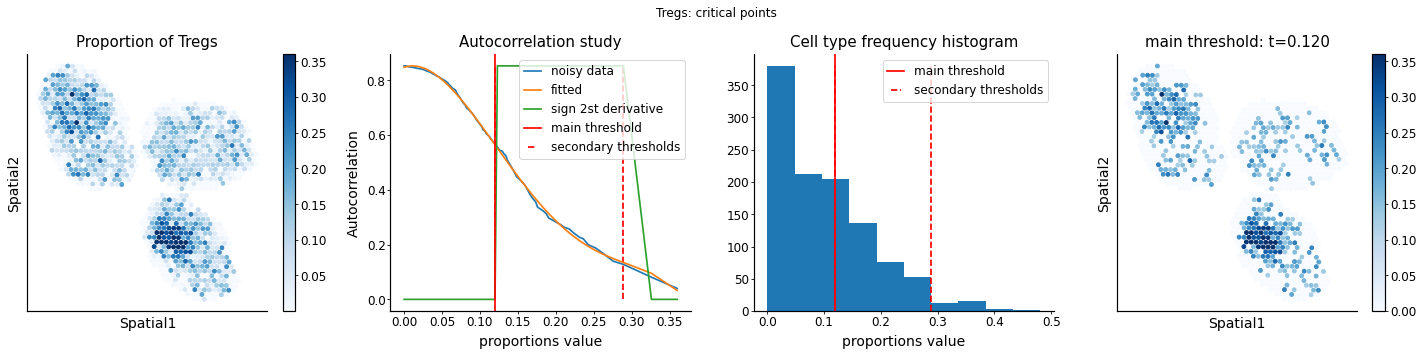

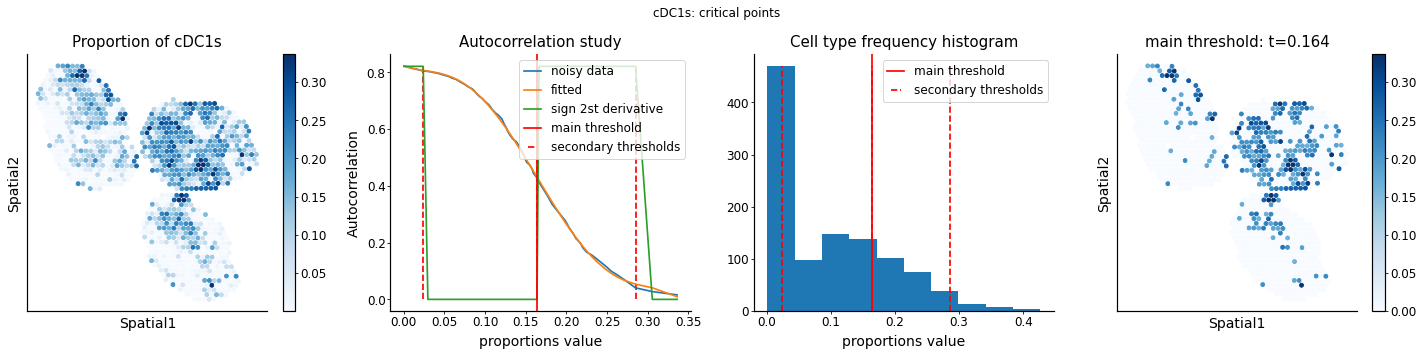

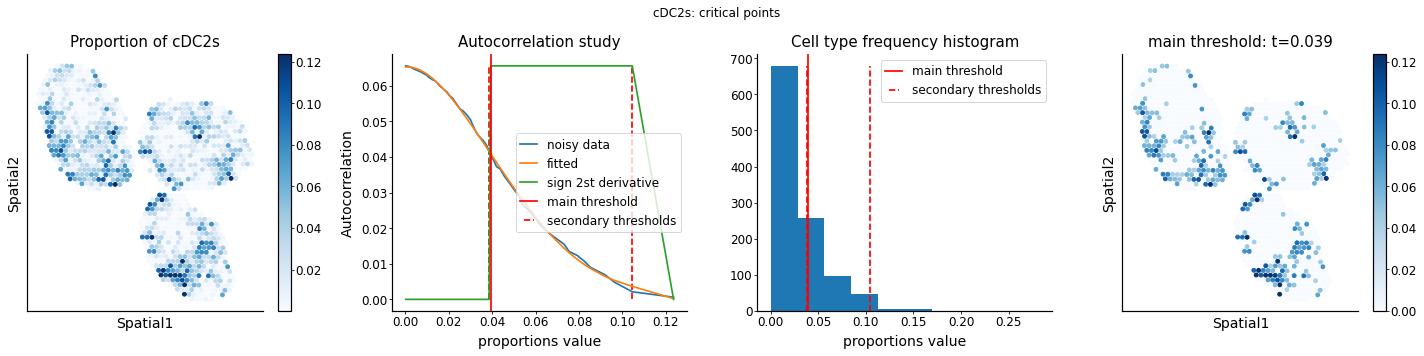

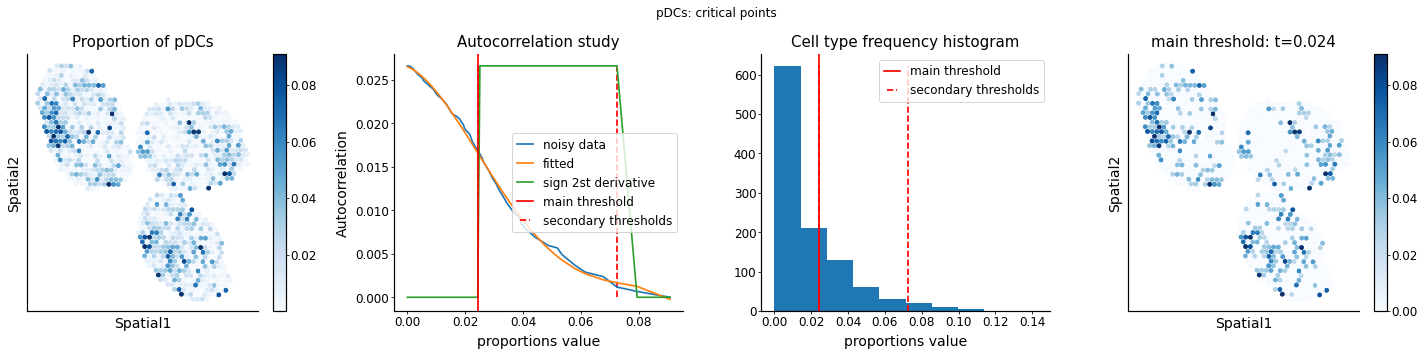

In [27]:
ct_thresholds = {}
nominal_threshold = {}

html = "<h2>Automatic thresholding</h2>"
for name_ct in ct_list:
    # show proportions
#     html += f"<h2>{name_ct} ANALYSIS:</h2>"
    array = st_adata.obsm["proportions"][name_ct]
    
    fig = plt.figure(figsize=(20, 5))
    fig.suptitle(name_ct+": critical points")
    ax1 = plt.subplot(141)
    prettify_axis(ax1, False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")
    vmax = np.quantile(array.values, 0.99)
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
            c=array, s=15, cmap="Blues", vmax=vmax)
    plt.colorbar()
    plt.title("Proportion of "+name_ct)

    # get characteristic values
    quantiles, stack = form_stacked_quantiles(array.values)
    index, z_values = get_autocorrelations(st_adata, stack, quantiles)
    z_values, smoothed, derivative, sign_2nd, _ = smooth_get_critical_points(index, z_values, s=0.1)

    #plot characteristic plots
    ymax = np.max(z_values)
    ax2 = plt.subplot(142)
    prettify_axis(ax2)
    plt.plot(index, z_values, label="noisy data")
    plt.plot(index, smoothed, label="fitted")
    plt.plot(index, ymax * sign_2nd, label="sign 2st derivative")
    # identify points
    ipoints = index[np.where(sign_2nd[:-1] != sign_2nd[1:])[0]]
    plt.vlines(ipoints, ymin=0, ymax=np.max(z_values), color="red", linestyle="--", label="secondary thresholds")
    # nominal mapping
    nom_map = index[np.argmin(derivative)]
    plt.axvline(nom_map, c="red", label="main threshold")
    plt.ylabel("Autocorrelation")
    plt.xlabel("proportions value")
    plt.title("Autocorrelation study")
    plt.legend()
    
    # plot on top of histogram
    ax3 = plt.subplot(143)
    prettify_axis(ax3)
    n, bins, patches = plt.hist(array.values)
    plt.vlines(ipoints, ymin=0, ymax=np.max(n), color="red", linestyle="--", label="secondary thresholds")
    # nominal mapping
    plt.axvline(nom_map, c="red", label="main threshold")
    plt.xlabel("proportions value")
    plt.title("Cell type frequency histogram")
    plt.legend()
    
    # add thresholds to dict
    nominal_threshold[name_ct] = nom_map
    ct_thresholds[name_ct] = ipoints
    
    ax4 = plt.subplot(144)
    prettify_axis(ax4, False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")    # show binarization for every ipoint
    p = nom_map
    vmax = np.quantile(array.values, 0.99)
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
                c=array.values * (array.values > p), s=15, cmap="Blues", vmax=vmax)
    plt.title("main threshold: t={:0.3f}".format(p))
    plt.colorbar()
    plt.tight_layout()
    
    # DUMP TO HTML
    tmpfile = BytesIO()
    plt.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    html += '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

# write HTML
with open('thresholding.html','w') as f:
    f.write(html)

In [26]:
# from left to right for every LN:
# 1. spatial location of thresholded value, 2. number of spots, 
# 3. reached auto-correlation, 4. normalized histogram

In [56]:
ct_profile = st_adata.obsm["proportions"].copy()
ct_profile["LN"] = st_adata.obs["LN"]

100%|██████████| 12/12 [00:00<00:00, 9830.40it/s]


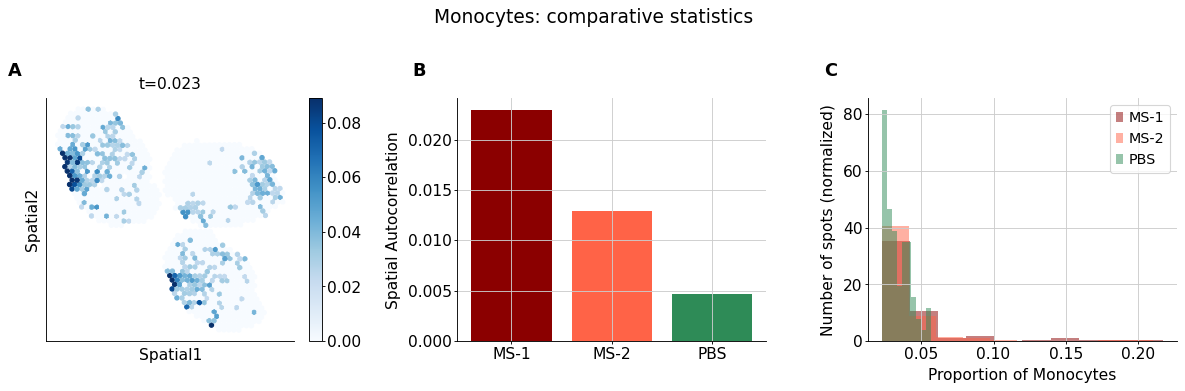

In [57]:
name_ct = "Monocytes"

labels=["TC", "BD", "TD"]
name_list = ["MS-1", "MS-2", "PBS"]
color_list = ["darkred", "tomato", "seagreen"]

fig = plt.figure(figsize=(15, 5))
fig.suptitle(name_ct+": comparative statistics")

# 1. spatial location of thresholded value
ax1 = plt.subplot(131)
ax1.text(-0.1, 1.15, "A", transform=ax1.transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')
prettify_axis(ax1, False)
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")
array = ct_profile[name_ct]
vmax = np.quantile(array.values, 0.99)
p = nominal_threshold[name_ct]
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
                    c=array.values * (array.values > p), s=15, cmap="Blues", vmax=vmax)
plt.colorbar()
plt.title("t={:0.3f}".format(p))
        
ax2 = plt.subplot(132)
ax2.text(-0.1, 1.15, "B", transform=ax2.transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')
z_values = []
for i in range(3):
    mask = st_adata.obs["LN"] == labels[i]
    loc = pd.DataFrame(data=st_adata.obsm["location"][mask], index=st_adata.obs.index[mask])
    matrix = st_adata.obsm["proportions"][mask].values.T 
    matrix = matrix * (matrix > p)
    df = pd.DataFrame(data=matrix, 
                      columns=st_adata.obs.index[mask], index=st_adata.obsm["proportions"].columns)
    # run hotspot
    hs = hotspot.Hotspot(df, model='none', latent=loc,)
    hs.create_knn_graph(
            weighted_graph=True, n_neighbors=10,
        )
    hs_results = hs.compute_autocorrelations(jobs=1)
    z_values.append(hs_results["Z"][name_ct])
plt.bar([0, 1, 2], z_values, color=color_list)
plt.xticks([0, 1, 2], labels=name_list)
plt.ylabel("Spatial Autocorrelation")

ax4=plt.subplot(133)
ax4.text(-0.1, 1.15, "C", transform=ax4.transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')
for i in range(3):
    array_ln = ct_profile[ct_profile["LN"] == labels[i]][name_ct]
    plt.hist(array_ln[array_ln > p], label=name_list[i], alpha=0.5, density=True, color=color_list[i])
plt.legend()
plt.xlabel(f"Proportion of {name_ct}")
plt.ylabel("Number of spots (normalized)")
plt.tight_layout()
plt.show()

In [59]:
name_ct = "NK cells"

labels=["TC", "BD", "TD"]
name_list = ["MS-1", "MS-2", "PBS"]
color_list = ["darkred", "tomato", "seagreen"]

fig = plt.figure(figsize=(15, 5))
fig.suptitle(name_ct+": comparative statistics")

# 1. spatial location of thresholded value
ax1 = plt.subplot(131)
ax1.text(-0.1, 1.15, "D", transform=ax1.transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')
prettify_axis(ax1, False)
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")
array = ct_profile[name_ct]
vmax = np.quantile(array.values, 0.95)
p = nominal_threshold[name_ct]
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
                    c=array.values * (array.values > p), s=15, cmap="Blues", vmax=vmax)
plt.colorbar()
plt.title("t={:0.3f}, clipped to 0.95".format(p))
        
ax2 = plt.subplot(132)
ax2.text(-0.1, 1.15, "E", transform=ax2.transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')

z_values = []
for i in range(3):
    mask = st_adata.obs["LN"] == labels[i]
    loc = pd.DataFrame(data=st_adata.obsm["location"][mask], index=st_adata.obs.index[mask])
    matrix = st_adata.obsm["proportions"][mask].values.T 
    matrix = matrix * (matrix > p)
    df = pd.DataFrame(data=matrix, 
                      columns=st_adata.obs.index[mask], index=st_adata.obsm["proportions"].columns)
    # run hotspot
    hs = hotspot.Hotspot(df, model='none', latent=loc,)
    hs.create_knn_graph(
            weighted_graph=True, n_neighbors=10,
        )
    hs_results = hs.compute_autocorrelations(jobs=1)
    z_values.append(hs_results["Z"][name_ct])
plt.bar([0, 1, 2], z_values, color=color_list)
plt.xticks([0, 1, 2], labels=name_list)
plt.ylabel("Spatial Autocorrelation")

ax4=plt.subplot(133)
ax4.text(-0.1, 1.15, "F", transform=ax4.transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')
for i in range(3):
    array_ln = ct_profile[ct_profile["LN"] == labels[i]][name_ct]
    plt.hist(array_ln[array_ln > p], label=name_list[i], alpha=0.5, density=True, color=color_list[i])
plt.legend()
plt.xlabel(f"Proportion of {name_ct}")
plt.ylabel("Number of spots (normalized)")
plt.tight_layout()
plt.show()

100%|██████████| 11/11 [00:00<00:00, 18854.66it/s]



Removing 1 undetected/non-varying genes


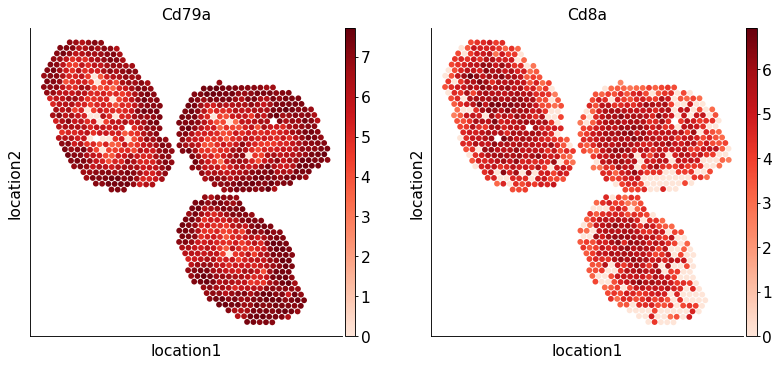

In [42]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

new_cmap = truncate_colormap(plt.get_cmap('Reds'), 0.1, 1)

sc.set_figure_params(figsize=(5, 5))
sc.pl.embedding(st_adata, "location", color=["Cd79a", "Cd8a"], cmap=new_cmap)
plt.show()

### Now, for every cell type, we wish to explore the gamma space
1. find the spatially principal axis of the gamma space
2. project the spatial data onto them
3. display associated genes with hotspot

/home/ubuntu/anaconda3/lib/python3.7/site-packages/cmap2d/util.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  bary_coords = la.lstsq(self._a,b)[0]
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ubuntu/destVI-paper-code/lymph_node/deconvolution/utils.py:136: RuntimeWarning: invalid value encountered in true_divide
  r = r_num/r_den


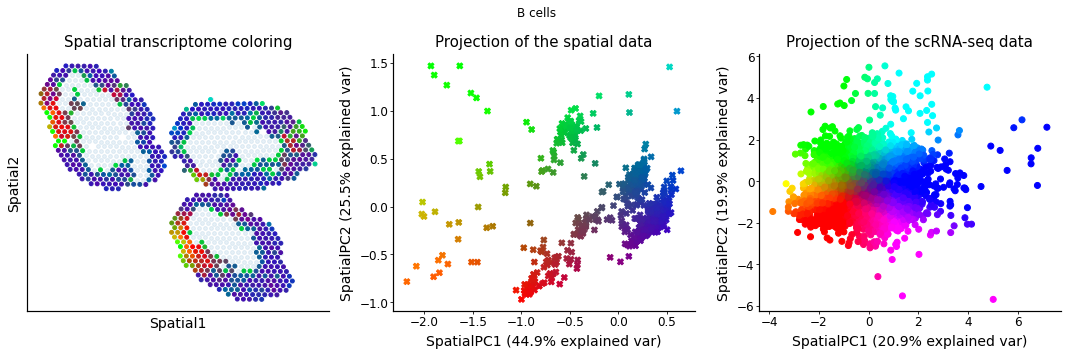

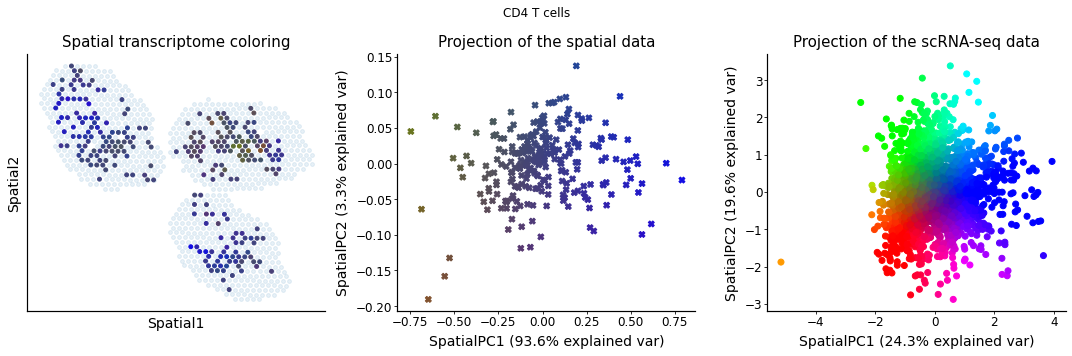

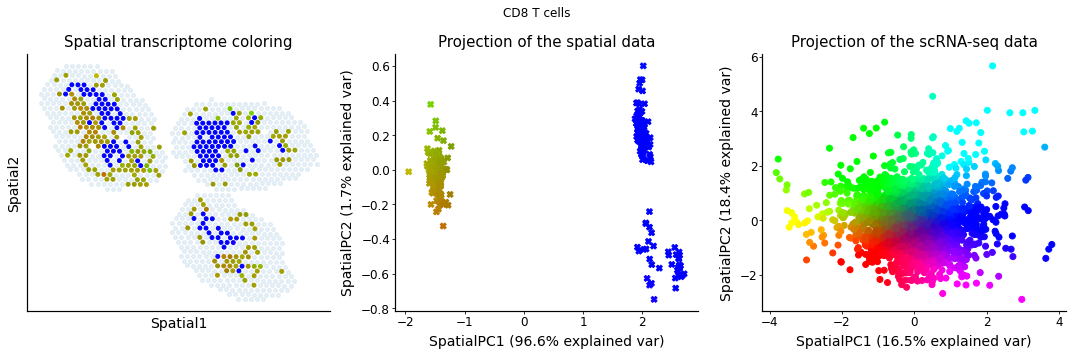

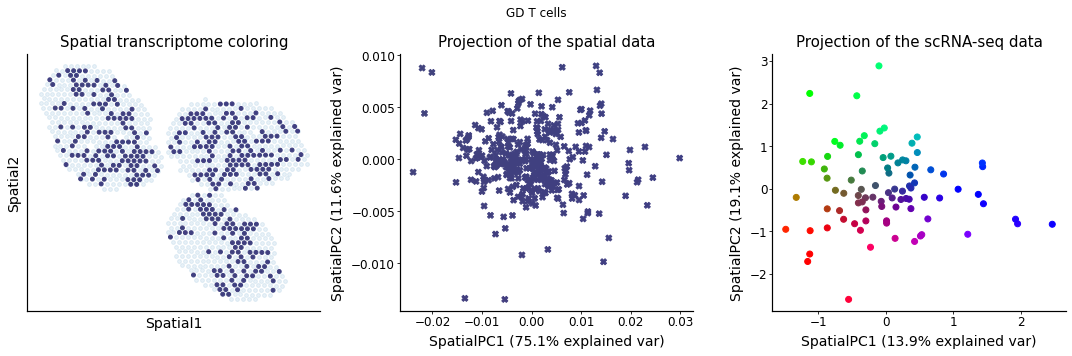

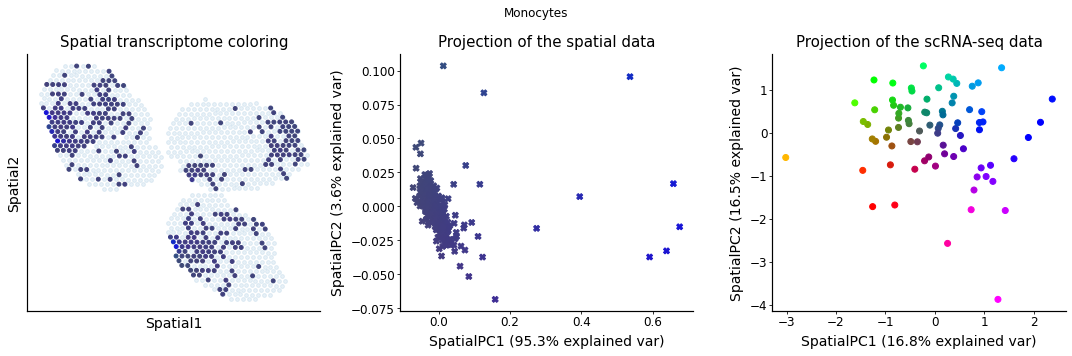

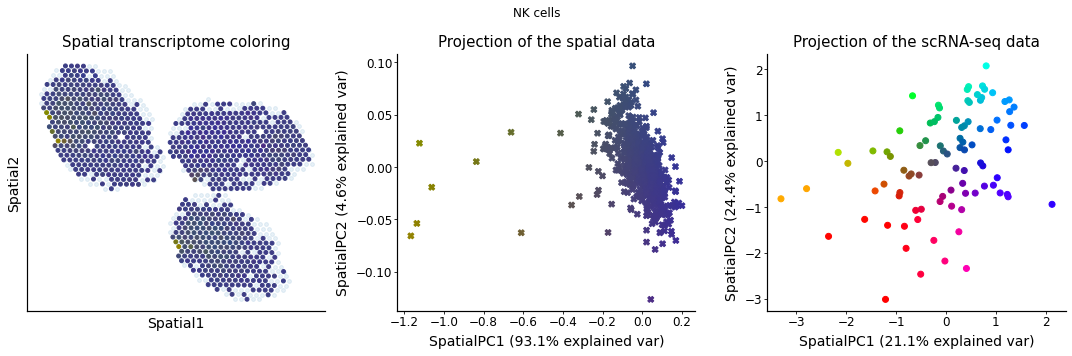

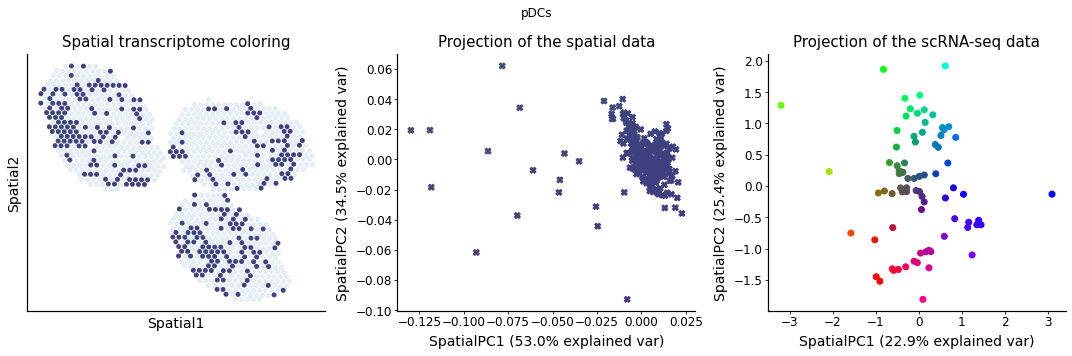

In [28]:
html = "<h1>sPCA analysis</h1>"

for name_ct in ct_list:
    # show proportions
#     html += f"<h3>{name_ct} ANALYSIS:</h2>"
    # find the components
    filter_ = st_adata.obsm["proportions"][name_ct].values > ct_thresholds[name_ct][0]
    locations = st_adata.obsm["location"][filter_]
    proportions = st_adata.obsm["proportions"][[name_ct]].values[filter_]
    ct_index = np.where(name_ct == st_model.cell_type_mapping)[0][0]
    data = gamma[:, :, ct_index][filter_]
    vec = get_spatial_components(locations, proportions, data)
    # project data onto them
    projection = np.dot(data - np.mean(data, 0), vec)

    # create the colormap
    cmap = cmap2d.TernaryColorMap(tri_coords, tri_colors)

    # apply colormap to spatial data
    color = np.vstack([cmap(projection[i]) for i in range(projection.shape[0])])
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(name_ct)
    ax1 = plt.subplot(132)
    prettify_axis(ax1)
    plt.scatter(projection[:, 0], projection[:, 1],c=color, marker="X")
    # variance and explained variance
    total_var = np.sum(np.diag(np.cov(data.T)))
    explained_var = 100 * np.diag(np.cov(projection.T)) / total_var 
    plt.xlabel("SpatialPC1 ({:.1f}% explained var)".format(explained_var[0]))
    plt.ylabel("SpatialPC2 ({:.1f}% explained var)".format(explained_var[1]))
    plt.title("Projection of the spatial data")

    ax3 = plt.subplot(131)
    prettify_axis(ax3, False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.1, s=15)
    plt.scatter(st_adata.obsm["location"][filter_, 0], st_adata.obsm["location"][filter_, 1], 
                c=color, s=15)
    plt.title("Spatial transcriptome coloring")

    # go back to the single-cell data and find gene correlated with the axis
    sc_data_slice = sc_adata[sc_adata.obs["broad_cell_types"] == name_ct]
    normalized_counts = sc_data_slice.X.A
    sc_latent = sc_data_slice.obsm["X_CondSCVI"]
    sc_projection = np.dot(sc_latent - np.mean(sc_latent,0), vec)

    # show the colormap for single-cell data
    color = np.vstack([cmap(sc_projection[i]) for i in range(sc_projection.shape[0])])
    ax2 = plt.subplot(133)
    prettify_axis(ax2)
    plt.scatter(sc_projection[:, 0], sc_projection[:, 1],c=color)
    # variance and explained variance
    total_var = np.sum(np.diag(np.cov(sc_latent.T)))
    explained_var = 100 * np.diag(np.cov(sc_projection.T)) / total_var 
    plt.xlabel("SpatialPC1 ({:.1f}% explained var)".format(explained_var[0]))
    plt.ylabel("SpatialPC2 ({:.1f}% explained var)".format(explained_var[1]))
    plt.title("Projection of the scRNA-seq data")
    plt.tight_layout()
    
    # DUMP TO HTML
    tmpfile = BytesIO()
    plt.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    html += '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    # calculate correlations, and for each axis: (A) display top 50 genes + AND - (B) for each gene set, get GSEA 
    for d in [0, 1]:
        html += f"<h4>Component:{d}</h4>"
        r = vcorrcoef(normalized_counts.T, sc_projection[:, d])
        for mode in ["top", "bottom"]:
            ranking = np.argsort(r)
            if mode == "top":
                ranking = ranking[::-1]
            gl = list(st_adata.var.index[ranking[:50]])
            enr = gseapy.enrichr(gene_list=gl, description='pathway', gene_sets='BioPlanet_2019', outdir='test', no_plot=True)
            html += f"<h5> {mode} </h5>"
            html += "<p>" + ", ".join(gl) + "</p>"
            html += "<p>" + ", ".join(enr.results.head(10)["Term"].values) + "</p>"
            
# write HTML
with open('sPCA.html','w') as f:
    f.write(html)

### Last piece of automated analysis, look for Hotspot modules in the imputed values

In [29]:
html = "<h1>Hotspot analysis</h1>"

for name_ct in ct_list:
    # show proportions
    html += f"<h5>{name_ct} ANALYSIS:</h5>"

    # get data
    filter_ = st_adata.obsm["proportions"][name_ct].values > ct_thresholds[name_ct][0]
    locations = st_adata.obsm["location"][filter_]
    proportions = st_adata.obsm["proportions"][[name_ct]].values[filter_]

    # impute
    imp_ge = st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0]).values

    # run hotspot
    loc = pd.DataFrame(data=locations, index=st_adata.obs.index[filter_])
    df = pd.DataFrame(data=imp_ge.T, 
                      columns=st_adata.obs.index[filter_], index=st_adata.var.index)
    # run hotspot
    hs = hotspot.Hotspot(df, model='none', latent=loc,)
    hs.create_knn_graph(
            weighted_graph=True, n_neighbors=5,
        )
    hs_results = hs.compute_autocorrelations(jobs=1)
    
    gl = list(hs_results.index[:50])
    enr = gseapy.enrichr(gene_list=gl, description='pathway', gene_sets='BioPlanet_2019', outdir='test', no_plot=True)

    # dump HTML
    html += "<p>" + ", ".join(gl) + "</p>"
    html += "<p>" + ", ".join(enr.results.head(10)["Term"].values) + "</p>"
    
# write HTML
with open('hotspot.html','w') as f:
    f.write(html)

100%|██████████| 1888/1888 [00:00<00:00, 3129.75it/s]


## then, quick API for plotting genes in a given cell type

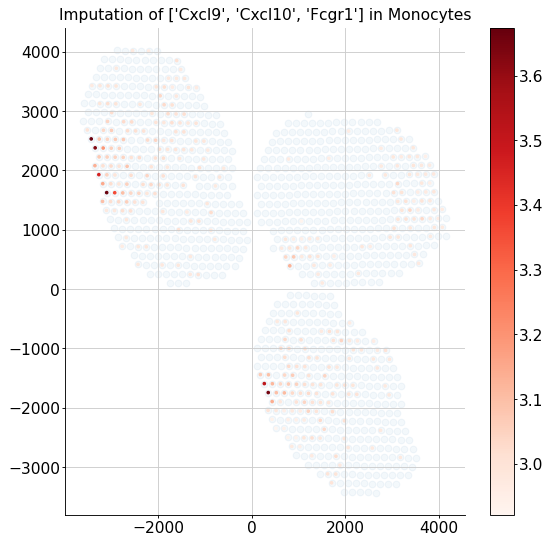

In [33]:
plt.figure(figsize=(8, 8))

name_ct = "Monocytes"
gene_name = ["Cxcl9", "Cxcl10", "Fcgr1"]


# get data
filter_ = st_adata.obsm["proportions"][name_ct].values > ct_thresholds[name_ct][0]
locations = st_adata.obsm["location"][filter_]
proportions = st_adata.obsm["proportions"][[name_ct]].values[filter_]

# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[gene_name].values, 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=5, cmap="Reds")
plt.colorbar()
plt.title(f"Imputation of {gene_name} in {name_ct}")
plt.show()

# Producing figures for the manuscript

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
color_list = ["darkred", "tomato", "seagreen"]
name_list = ["MS-1", "MS-2", "PBS"]
for i, value in enumerate(["TC", "BD", "TD"]):
    mask = st_adata.obs["LN"] == value
    ax.scatter(st_adata.obsm["location"][mask, 0], st_adata.obsm["location"][mask, 1], 
               c=color_list[i], label=name_list[i], s=10)
ax.legend()
prettify_axis(ax, False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Spatial1")
ax.set_ylabel("Spatial2")
plt.show()

##### B cells investigation

First, we identify a hotpot modules on the single-cell data. This can be done on the scLVM or as a standalone analysis (scVI, PCA, etc..). 

In [67]:
# run hotspot
name_ct = "B cells"
sc_adata_slice = sc_adata[sc_adata.obs["broad_cell_types"] == name_ct]
loc = pd.DataFrame(data=sc_adata_slice.obsm["X_CondSCVI"], index=sc_adata_slice.obs.index)
df = pd.DataFrame(data=sc_adata_slice.X.A.T, columns=sc_adata_slice.obs.index, index=sc_adata_slice.var.index)
# run hotspot
hs = hotspot.Hotspot(df, model='danb', latent=loc,)
hs.create_knn_graph(
        weighted_graph=True, n_neighbors=20,
    )
hs_results = hs.compute_autocorrelations(jobs=1)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)



Removing 24 undetected/non-varying genes


100%|██████████| 1864/1864 [00:01<00:00, 1492.06it/s]


In [68]:
hs_genes = hs_results.index[hs_results["FDR"] < 0.0005]
hs_genes

Index(['Ifit3', 'Cd74', 'H2-Aa', 'H2-Eb1', 'Cd79a', 'H2-Ab1', 'Malat1', 'Igkc',
       'Ly6d', 'Mef2c',
       ...
       'Gsap', 'Msmo1', 'Adm', 'Lmo4', 'Cd27', 'P4hb', 'Aqp9', 'Ptger4', 'Ddt',
       'Asph'],
      dtype='object', name='Gene', length=1062)

 28%|██▊       | 300/1062 [00:00<00:00, 2999.60it/s]

Computing pair-wise local correlation on 1062 features...


100%|██████████| 563391/563391 [05:41<00:00, 1651.93it/s]


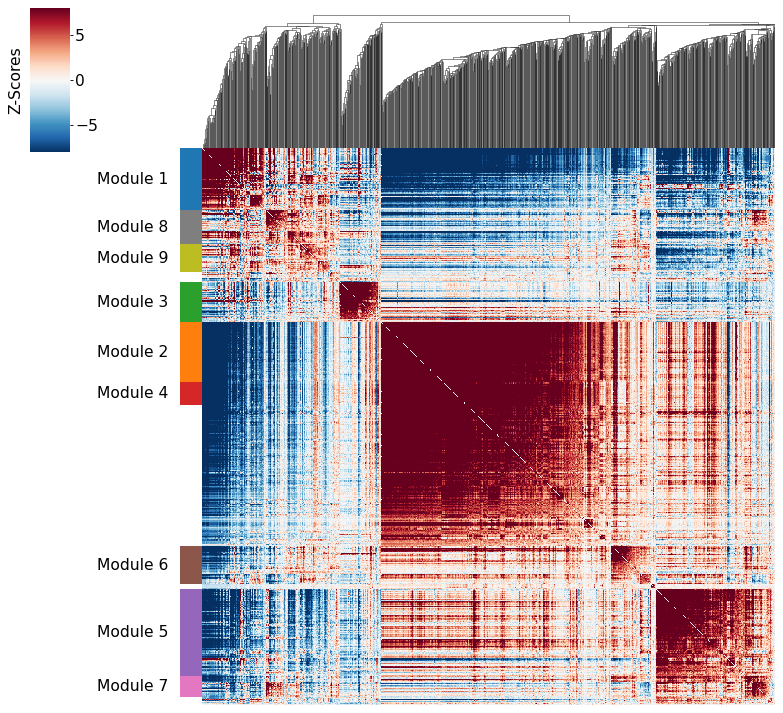

In [69]:
local_correlations = hs.compute_local_correlations(hs_genes, jobs=4)

modules = hs.create_modules(
    min_gene_threshold=30, core_only=True, fdr_threshold=0.05
)

hs.plot_local_correlations()

In [71]:
hs.modules[["Ifit3", "Ifit1", "Usp18"]]

Gene
Ifit3    3
Ifit1    3
Usp18    3
Name: Module, dtype: int64

In [259]:
len(np.where(hs.modules == 4)[0])

82

In [261]:
gl = list(hs.results.loc[hs.modules.index[np.where(hs.modules == 3)[0]]].index[:50])
print(", ".join(gl) + "\n")
enr = gseapy.enrichr(gene_list=gl, description='pathway', gene_sets='BioPlanet_2019', outdir='test', no_plot=True)
print(", ".join(enr.results.head(10)["Term"].values))

Ifit3, Ifit3b, Usp18, Irf7, Slfn5, Stat1, Rsad2, Ifit1, Ifi47, Rtp4, Ifit2, Zbp1, Isg15, Serpina3g, Ifi27l2a, Oasl2, Plac8, Oas3, Trim30a, Gbp7, Ly6a, Igtp, Bst2, Isg20, Irf1, Parp14, Ms4a4c, Gbp4, Serpina3f, Rnf213, Pkib, Ifitm3, Phf11b, Psmb9, Socs1, Eif2ak2, Cmpk2, Herc6, Sdc3, Lgals3bp, Cybb, Tspo, Gbp2, Trafd1, Hsph1, Phf11a, Sp140, Gbp5, Gbp3, Epsti1

Interferon signaling, Interferon alpha/beta signaling, Immune system signaling by interferons, interleukins, prolactin, and growth hormones, Immune system, Interferon-gamma signaling pathway, Type II interferon signaling (interferon-gamma), Antiviral mechanism by interferon-stimulated genes, Interferon alpha signaling regulation, Toll-like receptor signaling pathway regulation, Interferon gamma signaling regulation


In [60]:
name_ct = "B cells"

# STEP1: extract relevant data
# spatial data
threshold_ = 0.2
proportions = st_adata.obsm["proportions"][name_ct].values
filter_ = proportions > threshold_
proportions = proportions[filter_]
index = st_adata.obs.index[filter_]
locations = st_adata.obsm["location"][filter_]
ln_label = st_adata.obs["LN"][filter_]
ct_index = np.where(name_ct == st_model.cell_type_mapping)[0][0]
data = gamma[:, :, ct_index][filter_]
# single cell data
sc_adata_slice = sc_adata[sc_adata.obs["broad_cell_types"] == name_ct]
normalized_counts = sc_adata_slice.X
sc_latent = sc_adata_slice.obsm["X_CondSCVI"]

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [61]:
#STEP: embed sc data
dim_red = umap.UMAP(n_neighbors=50)
result = dim_red.fit_transform(sc_adata_slice.obsm["X_CondSCVI"])

In [48]:
# Main figure
fig = plt.figure(figsize=(10, 5))

gene_name = ['Ifit3', 'Ifit3b', 'Stat1', 'Ifit1', 'Usp18', 'Isg15']
gene_idx = np.where([x in gene_name for x in st_adata.var.index])[0]


# joint embedding and selection of gamma star
ax1 = plt.subplot(121)

prettify_axis(ax1, False)
ind_xx = 0
ind_yy = 3
plt.scatter(sc_latent[:, ind_xx], sc_latent[:, ind_yy], c = np.mean(normalized_counts[:, gene_idx].A, 1), 
            s=12, cmap="magma_r")
cbar = plt.colorbar()
cbar.set_label("IFN-I module expression")
plt.scatter(data[:, ind_xx], data[:, ind_yy], marker="x", s=20, c="black")#, fill=False, alpha=0.5, cmap="autumn")
origin = [0, 0]
handles = [Line2D([0], [0], marker='o', color='w', label='scRNA-seq',
                        markerfacecolor=plt.cm.summer(100), markersize=5),
            Line2D([0], [0], marker='X', color='w', label='Spatial',
                        markerfacecolor="black", markersize=5)]
plt.legend(handles=handles, frameon=True)
star_gamma = np.array([-2, -0.5])
plt.xlim((-6, 6))
origin = [0, 0]
# plt.quiver(*origin, star_gamma[[0]], star_gamma[[1]], color=['r'], scale=5)
# plt.text( star_gamma[[0]] - 3.5,  star_gamma[[0]] + 1, r"$\gamma^*$", color="r")
plt.xlabel("Gamma0")
plt.ylabel("Gamma3")
plt.title("Joint embedding")

# imputation of gene on spatial
ax2 = plt.subplot(122)
prettify_axis(ax2)

# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[gene_name].values, 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
vmin = np.quantile(imp_ge, 0.01)
vmax = np.quantile(imp_ge, 0.99)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=12, cmap="Reds", vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f"Imputation of IFN-I module in {name_ct}")
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")

plt.tight_layout()
plt.savefig("figures/B_cells_invest.pdf")


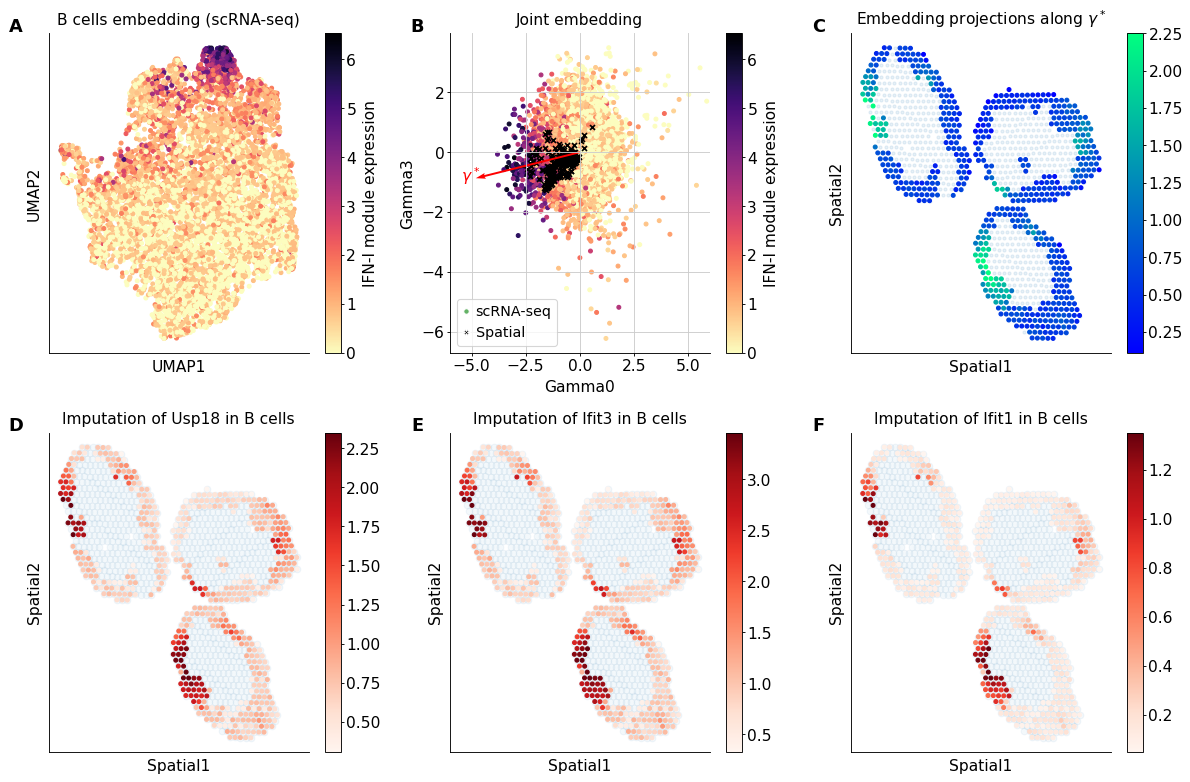

In [64]:
# Supp figure (top)
fig = plt.figure(figsize=(15, 10))

gene_name = ['Ifit3', 'Ifit3b', 'Stat1', 'Ifit1', 'Usp18', 'Isg15']
gene_idx = np.where([x in gene_name for x in st_adata.var.index])[0]


# ax1: B cells transcriptome with IFIT3
ax1 = plt.subplot(231)
ax1.text(-0.1, 1.05, "A", transform=ax1.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
prettify_axis(ax1, False)
plt.scatter(result[:, 0], result[:, 1], c=np.mean(sc_adata_slice.X[:, gene_idx].A, 1), s=12, cmap="magma_r")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title(f"{name_ct} embedding (scRNA-seq)")
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label("IFN-I module expression")

# joint embedding and selection of gamma star
ax2 = plt.subplot(232)
ax2.text(-0.1, 1.05, "B", transform=ax2.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
prettify_axis(ax2, False)
ind_xx = 0
ind_yy = 3
plt.scatter(sc_latent[:, ind_xx], sc_latent[:, ind_yy], c = np.mean(normalized_counts[:, gene_idx].A, 1), 
            s=12, cmap="magma_r")
cbar = plt.colorbar()
cbar.set_label("IFN-I module expression")
plt.scatter(data[:, ind_xx], data[:, ind_yy], marker="x", s=20, c="black")#, fill=False, alpha=0.5, cmap="autumn")
origin = [0, 0]
handles = [Line2D([0], [0], marker='o', color='w', label='scRNA-seq',
                        markerfacecolor=plt.cm.summer(100), markersize=5),
            Line2D([0], [0], marker='X', color='w', label='Spatial',
                        markerfacecolor="black", markersize=5)]
plt.legend(handles=handles, frameon=True)
star_gamma = np.array([-2, -0.5])
plt.xlim((-6, 6))
origin = [0, 0]
plt.quiver(*origin, star_gamma[[0]], star_gamma[[1]], color=['r'], scale=5)
plt.text( star_gamma[[0]] - 3.5,  star_gamma[[0]] + 1, r"$\gamma^*$", color="r")
plt.xlabel("Gamma0")
plt.ylabel("Gamma3")
plt.title("Joint embedding")

# visualization of gamma star on spatial
ax3 = plt.subplot(233)
ax3.text(-0.1, 1.05, "C", transform=ax3.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
prettify_axis(ax3)
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.1, s=8)
color = (star_gamma[0] * data[:, ind_xx] + star_gamma[1] * data[:, ind_yy])/ np.sqrt(sum(star_gamma**2))
vmin = np.quantile(color, 0.01)
vmax = np.quantile(color, 0.99)
plt.scatter(st_adata.obsm["location"][filter_, 0], st_adata.obsm["location"][filter_, 1], 
            c=color, s=12, vmin=vmin, vmax=vmax, cmap="winter")
plt.title(f"Embedding projections along $\gamma^*$")
plt.colorbar()
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")

# imputation of gene on spatial
ax4 = plt.subplot(234)
ax4.text(-0.1, 1.05, "D", transform=ax4.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
prettify_axis(ax4)

# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[["Usp18"]].values, 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
vmin = np.quantile(imp_ge, 0.01)
vmax = np.quantile(imp_ge, 0.99)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=12, cmap="Reds", vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f"Imputation of Usp18 in {name_ct}")
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")

# imputation of gene on spatial
ax4 = plt.subplot(235)
prettify_axis(ax4)
ax4.text(-0.1, 1.05, "E", transform=ax4.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[["Ifit3"]].values, 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
vmin = np.quantile(imp_ge, 0.01)
vmax = np.quantile(imp_ge, 0.99)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=12, cmap="Reds", vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f"Imputation of Ifit3 in {name_ct}")
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")

# imputation of gene on spatial
ax4 = plt.subplot(236)
prettify_axis(ax4)
ax4.text(-0.1, 1.05, "F", transform=ax4.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[["Ifit1"]].values, 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
vmin = np.quantile(imp_ge, 0.01)
vmax = np.quantile(imp_ge, 0.99)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=12, cmap="Reds", vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f"Imputation of Ifit1 in {name_ct}")
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")

plt.tight_layout()
plt.savefig("figures/supp_B_cells_invest.pdf")

In [51]:
# impute 
imp_ge = st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0]).values

# get statistics
avg_library_size = np.mean(np.sum(st_adata.layers["counts"], axis=1).A.flatten())
exp_px_o = st_model.module.px_o.detach().exp().cpu().numpy()
mean = avg_library_size * imp_ge

# create distribution
concentration = torch.tensor(avg_library_size * imp_ge / exp_px_o)
rate = torch.tensor(1. / exp_px_o)

# slice conditions
mask_ms = np.logical_or(ln_label == "TC", ln_label == "BD").values
mask_pbs = (ln_label == "TD").values

# generate
N = 8
simulated_case = Gamma(concentration=concentration[mask_ms], rate = rate).sample((N,)).cpu().numpy()
simulated_case = np.log(simulated_case + 1)
simulated_case = simulated_case.reshape((-1, simulated_case.shape[-1]))

simulated_control = Gamma(concentration=concentration[mask_pbs], rate = rate).sample((2 * N,)).cpu().numpy()
simulated_control = np.log(simulated_control + 1)
simulated_control = simulated_control.reshape((-1, simulated_control.shape[-1]))

In [52]:
np.sum(mask_ms), np.sum(mask_pbs)

(370, 188)

In [53]:
# differential expression

de_ks =np.array([ks_2samp(simulated_case[:, gene], 
                       simulated_control[:, gene], 
                       alternative='two-sided').pvalue for gene in range(simulated_control.shape[1])])
# de_t_test =np.array([ttest_ind(simulated_case[:, gene], 
#                        simulated_control[:, gene], 
#                        alternative='two-sided').pvalue for gene in range(simulated_control.shape[1])])

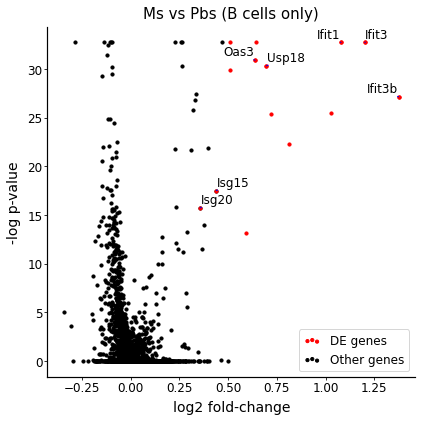

In [54]:
de = de_ks
max_pval = np.max(de[multipletests(de, method='fdr_bh')[0]])
lfc = np.log2(mean[mask_ms].mean(0)) - np.log2(mean[mask_pbs].mean(0))
plt.figure(figsize=(6, 6))
# plot DE genes
mask = (de < max_pval) * (np.abs(lfc) > 0.5)
de_scatter = plt.scatter(lfc[mask], np.clip(-np.log(de[mask]), 0, 40), s=10, c="r")
nde_scatter = plt.scatter(lfc[~mask], np.clip(-np.log(de[~mask]), 0, 40), s=10, c="black")
plt.xlabel("log2 fold-change")
plt.ylabel("-log p-value")

plt.legend((de_scatter, nde_scatter), ("DE genes", "Other genes"), frameon=True)

interesting_genes = ["Ifit3", "Ifit3b", "Ifit1", "Isg15", "Oas3", "Usp18", "Isg20"]
texts = []
for i, gene in enumerate(interesting_genes):
    ind = np.where(st_adata.var.index == gene)[0]
    x_coord, y_coord = lfc[ind], -np.log(de)[ind]
    plt.scatter(x_coord, y_coord, c="r", s=10)
    texts += [plt.text(x_coord, y_coord, gene, fontsize=12)]
adjust_text(texts, lfc, -np.log(de), arrowprops=dict(arrowstyle="-", color='blue'))
plt.title("Ms vs Pbs (B cells only)")
plt.tight_layout()
plt.savefig("figures/volcano_B_cells.pdf", dpi=DPI)

In [55]:
print("Ms enriched: " + ", ".join(st_adata.var.index[np.where((lfc > 0.5) * (de < max_pval ))[0]].values))
print("Pbs enriched: " + ", ".join(st_adata.var.index[np.where((lfc < -0.5) * (de < max_pval ))[0]].values))

Ms enriched: Ifi44, Ifit1, Ifit2, Ifit3, Ifit3b, Irf7, Oas3, Oasl2, Rsad2, Sdc3, Slfn5, Usp18
Pbs enriched: 


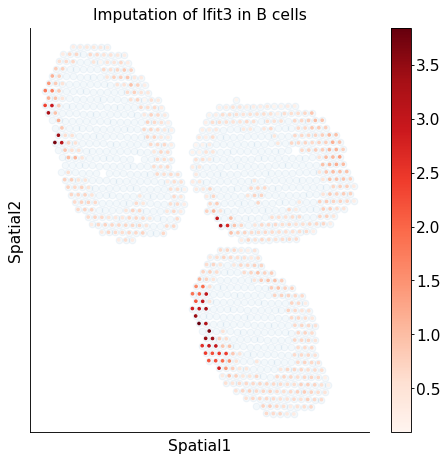

In [91]:
plt.figure(figsize=(6, 6))

name_ct = "B cells"
gene_name = ["Ifit3"]


# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[gene_name].values, 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=5, cmap="Reds")
plt.colorbar()
plt.title(f"Imputation of {gene_name[0]} in {name_ct}")
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")
plt.tight_layout()
plt.savefig("figures/B_cells_IFIT.pdf")

#### Monocytes investigation
First, we identify a hotpot modules on the single-cell data. This can be done on the scLVM or as a standalone analysis (scVI, PCA, etc..). 

In [92]:
# run hotspot
name_ct = "Monocytes"
sc_adata_slice = sc_adata[sc_adata.obs["broad_cell_types"] == name_ct]
loc = pd.DataFrame(data=sc_adata_slice.obsm["X_CondSCVI"], index=sc_adata_slice.obs.index)
df = pd.DataFrame(data=sc_adata_slice.X.A.T, columns=sc_adata_slice.obs.index, index=sc_adata_slice.var.index)
# run hotspot
hs = hotspot.Hotspot(df, model='danb', latent=loc,)
hs.create_knn_graph(
        weighted_graph=False, n_neighbors=5,
    )
hs_results = hs.compute_autocorrelations(jobs=1)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
100%|██████████| 1579/1579 [00:00<00:00, 11280.18it/s]


Removing 309 undetected/non-varying genes


In [93]:
hs_genes = hs_results.index[hs_results["FDR"] < 0.05]
hs_genes

Index(['Dnase1l3', 'Hp', 'H2-Eb1', 'H2-Aa', 'Ace', 'Vcam1', 'Fabp4', 'Fn1',
       'Cxcl9', 'H2-Ab1',
       ...
       'Siva1', 'Sfxn1', 'Tns1', 'Ms4a6d', 'Cd83', 'Gjb2', 'Adora2a', 'C1qbp',
       'Csf1', 'Ctsd'],
      dtype='object', name='Gene', length=321)

In [96]:
local_correlations = hs.compute_local_correlations(hs_genes, jobs=4)

modules = hs.create_modules(
    min_gene_threshold=10, core_only=True, fdr_threshold=0.05
)

hs.plot_local_correlations()

100%|██████████| 321/321 [00:00<00:00, 9304.44it/s]

Computing pair-wise local correlation on 321 features...



100%|██████████| 51360/51360 [00:06<00:00, 7995.20it/s] 


In [97]:
hs.modules[["Cxcl10", "Fcgr1", "Isg15"]]

Gene
Cxcl10    9
Fcgr1     9
Isg15     9
Name: Module, dtype: int64

In [305]:
len(np.where(hs.modules == 9)[0])

20

In [304]:
gl = list(hs.results.loc[hs.modules.index[np.where(hs.modules == 9)[0]]].index[:50])
print(", ".join(gl) + "\n")
enr = gseapy.enrichr(gene_list=gl, description='pathway', gene_sets='BioPlanet_2019', outdir='test', no_plot=True)
print(", ".join(enr.results.head(10)["Term"].values))

Ifi47, Cxcl10, Cd36, Gbp5, Clec4e, Fcgr1, Gbp7, Isg15, Igtp, Ifi204, Socs1, Ifi205, Fgl2, Fcgr4, Gbp3, Clic4, Trim30a, Dok2, Snx10, Oasl2

Interferon signaling, Interferon-gamma signaling pathway, Immune system signaling by interferons, interleukins, prolactin, and growth hormones, Type II interferon signaling (interferon-gamma), Immune system, Interferon alpha/beta signaling, RIG-I-like receptor signaling pathway, Interleukin-4 signaling pathway, Cross-presentation of particulate exogenous antigens (phagosomes), TSP1-induced apoptosis in microvascular endothelial cell


In [65]:
name_ct = "Monocytes"

# STEP1: extract relevant data
# spatial data
threshold_ = 0.03
proportions = st_adata.obsm["proportions"][name_ct].values
filter_ = proportions > threshold_
proportions = proportions[filter_]
index = st_adata.obs.index[filter_]
locations = st_adata.obsm["location"][filter_]
ln_label = st_adata.obs["LN"][filter_]
ct_index = np.where(name_ct == st_model.cell_type_mapping)[0][0]
data = gamma[:, :, ct_index][filter_]
# single cell data
sc_adata_slice = sc_adata[sc_adata.obs["broad_cell_types"] == name_ct]
normalized_counts = sc_adata_slice.X
sc_latent = sc_adata_slice.obsm["X_CondSCVI"]

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [66]:
#STEP: embed sc data
from sklearn.decomposition import SparsePCA
dim_red = SparsePCA(n_components=2)
result = dim_red.fit_transform(sc_adata_slice.X.A)

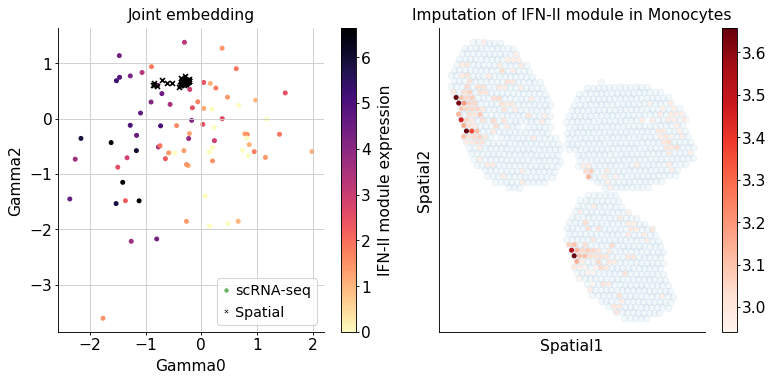

In [53]:
fig = plt.figure(figsize=(10, 5))

gene_name = ['Cxcl10', 'Cxcl9', 'Fcgr1']
gene_idx = np.where([x in gene_name for x in st_adata.var.index])[0]

# joint embedding and selection of gamma star
ax2 = plt.subplot(121)
prettify_axis(ax2, False)
ind_xx = 0
ind_yy = 3
plt.scatter(sc_latent[:, ind_xx], sc_latent[:, ind_yy], c = np.mean(normalized_counts[:, gene_idx].A, 1), 
            s=12, cmap="magma_r")
cbar = plt.colorbar()
cbar.set_label("IFN-II module expression")
plt.scatter(data[:, ind_xx], data[:, ind_yy], marker="x", s=20, c="black")#, fill=False, alpha=0.5, cmap="autumn")
origin = [0, 0]
handles = [Line2D([0], [0], marker='o', color='w', label='scRNA-seq',
                        markerfacecolor=plt.cm.summer(100), markersize=5),
            Line2D([0], [0], marker='X', color='w', label='Spatial',
                        markerfacecolor="black", markersize=5)]
plt.legend(handles=handles, frameon=True)
# star_gamma = np.array([-1, 1])
# origin = [0, 0]
# plt.quiver(*origin, star_gamma[[0]], star_gamma[[1]], color=['r'], scale=5)
# plt.text( star_gamma[[0]] +0.25,  star_gamma[[0]] + 2.25, r"$\gamma^*$", color="r")
plt.xlabel("Gamma0")
plt.ylabel("Gamma2")
plt.title("Joint embedding")

# imputation of gene on spatial
ax4 = plt.subplot(122)
prettify_axis(ax4)

# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[gene_name].values, 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
vmin = np.quantile(imp_ge, 0.01)
vmax = np.quantile(imp_ge, 0.99)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=12, cmap="Reds", vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f"Imputation of IFN-II module in {name_ct}")
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")

plt.tight_layout()
plt.savefig("figures/Monocytes_invest.pdf")

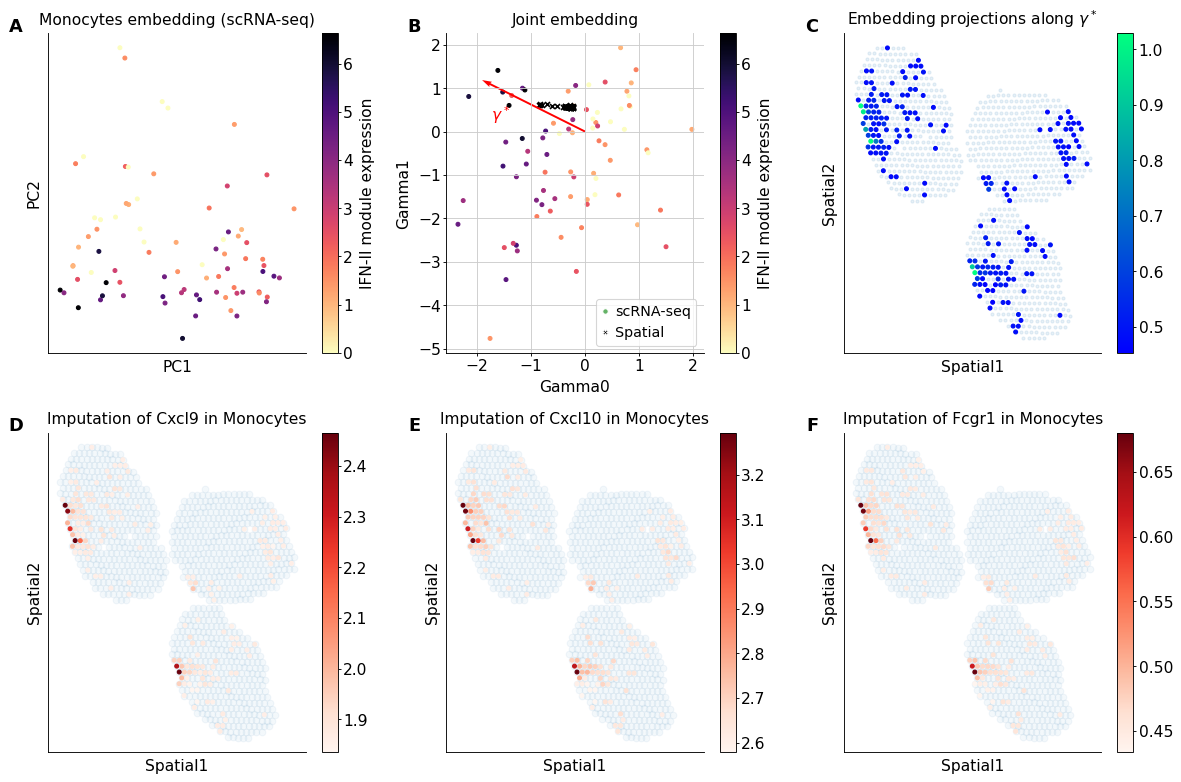

In [67]:
fig = plt.figure(figsize=(15, 10))

gene_name = ['Cxcl10', 'Cxcl9', 'Fcgr1']
gene_idx = np.where([x in gene_name for x in st_adata.var.index])[0]


# ax1: B cells transcriptome with IFIT3
ax1 = plt.subplot(231)
ax1.text(-0.1, 1.05, "A", transform=ax1.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
prettify_axis(ax1, False)
plt.scatter(result[:, 0], result[:, 1], c=np.mean(sc_adata_slice.X[:, gene_idx].A, 1), s=12, cmap="magma_r")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"{name_ct} embedding (scRNA-seq)")
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label("IFN-II module expression")

# joint embedding and selection of gamma star
ax2 = plt.subplot(232)
ax2.text(-0.1, 1.05, "B", transform=ax2.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
prettify_axis(ax2, False)
ind_xx = 0
ind_yy = 1
plt.scatter(sc_latent[:, ind_xx], sc_latent[:, ind_yy], c = np.mean(normalized_counts[:, gene_idx].A, 1), 
            s=12, cmap="magma_r")
cbar = plt.colorbar()
cbar.set_label("IFN-II module expression")
plt.scatter(data[:, ind_xx], data[:, ind_yy], marker="x", s=20, c="black")#, fill=False, alpha=0.5, cmap="autumn")
origin = [0, 0]
handles = [Line2D([0], [0], marker='o', color='w', label='scRNA-seq',
                        markerfacecolor=plt.cm.summer(100), markersize=5),
            Line2D([0], [0], marker='X', color='w', label='Spatial',
                        markerfacecolor="black", markersize=5)]
plt.legend(handles=handles, frameon=True)
star_gamma = np.array([-2, 1])
origin = [0, 0]
plt.quiver(*origin, star_gamma[[0]], star_gamma[[1]], color=['r'], scale=5)
plt.text( star_gamma[[0]] +0.25,  star_gamma[[0]] + 2.25, r"$\gamma^*$", color="r")
plt.xlabel("Gamma0")
plt.ylabel("Gamma1")
plt.title("Joint embedding")

# visualization of gamma star on spatial
ax3 = plt.subplot(233)
ax3.text(-0.1, 1.05, "C", transform=ax3.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
prettify_axis(ax3)
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.1, s=8)
color = (star_gamma[0] * data[:, ind_xx] + star_gamma[1] * data[:, ind_yy])/ np.sqrt(sum(star_gamma**2))
vmin = np.quantile(color, 0.01)
vmax = np.quantile(color, 0.99)
plt.scatter(st_adata.obsm["location"][filter_, 0], st_adata.obsm["location"][filter_, 1], 
            c=color, s=12, vmin=vmin, vmax=vmax, cmap="winter")
plt.title(f"Embedding projections along $\gamma^*$")
plt.colorbar()
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")

# imputation of gene on spatial
ax4 = plt.subplot(234)
ax4.text(-0.1, 1.05, "D", transform=ax4.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
prettify_axis(ax4)

# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[["Cxcl9"]].values, 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
vmin = np.quantile(imp_ge, 0.01)
vmax = np.quantile(imp_ge, 0.99)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=12, cmap="Reds", vmin=vmin, vmax=vmax)

plt.colorbar()
plt.title(f"Imputation of Cxcl9 in {name_ct}")
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")

# imputation of gene on spatial
ax4 = plt.subplot(235)
ax4.text(-0.1, 1.05, "E", transform=ax4.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
prettify_axis(ax4)

# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[["Cxcl10"]].values, 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
vmin = np.quantile(imp_ge, 0.01)
vmax = np.quantile(imp_ge, 0.99)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=12, cmap="Reds", vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f"Imputation of Cxcl10 in {name_ct}")
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")

# imputation of gene on spatial
ax4 = plt.subplot(236)
ax4.text(-0.1, 1.05, "F", transform=ax4.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
prettify_axis(ax4)

# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[["Fcgr1"]].values, 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
vmin = np.quantile(imp_ge, 0.01)
vmax = np.quantile(imp_ge, 0.99)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=12, cmap="Reds", vmin=vmin, vmax=vmax)

plt.colorbar()
plt.title(f"Imputation of Fcgr1 in {name_ct}")
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")

plt.tight_layout()
plt.savefig("figures/supp_Monocytes_invest.pdf")

In [87]:
# impute 
imp_ge = st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0]).values

# get statistics
avg_library_size = np.mean(np.sum(st_adata.layers["counts"], axis=1).A.flatten())
exp_px_o = st_model.module.px_o.detach().exp().cpu().numpy()
mean = avg_library_size * imp_ge

# create distribution
concentration = torch.tensor(avg_library_size * imp_ge / exp_px_o)
rate = torch.tensor(1. / exp_px_o)

# slice conditions
mask_ms = np.logical_and(np.logical_or(ln_label == "TC", ln_label == "BD").values, proportions > 0.04)
mask_pbs = (ln_label == "TD").values

print(np.sum(mask_ms), np.sum(mask_pbs))

# generate 
N = 40
simulated_case = Gamma(concentration=concentration[mask_ms], rate = rate).sample((N,)).cpu().numpy()
simulated_case = np.log(simulated_case + 1)
simulated_case = simulated_case.reshape((-1, simulated_case.shape[-1]))

simulated_control = Gamma(concentration=concentration[mask_pbs], rate = rate).sample((2*N,)).cpu().numpy()
simulated_control = np.log(simulated_control + 1)
simulated_control = simulated_control.reshape((-1, simulated_control.shape[-1]))

73 41


In [88]:
from scipy.stats import ttest_ind
# differential expression

de_ks =np.array([ks_2samp(simulated_case[:, gene], 
                       simulated_control[:, gene], 
                       alternative='two-sided').pvalue for gene in range(simulated_control.shape[1])])
# de_t_test =np.array([ttest_ind(simulated_case[:, gene], 
#                        simulated_control[:, gene], 
#                        alternative='two-sided').pvalue for gene in range(simulated_control.shape[1])])


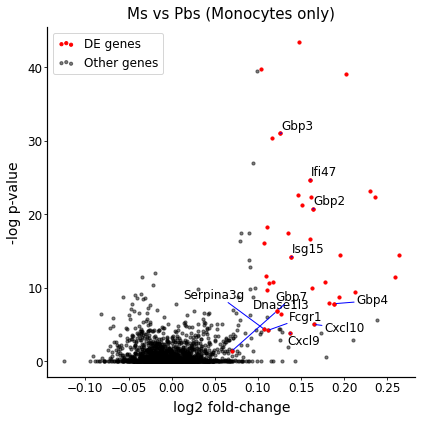

In [89]:
de = de_ks
max_pval = np.max(de[multipletests(de, method='fdr_bh')[0]])
lfc = np.log2(mean[mask_ms].mean(0)) - np.log2(mean[mask_pbs].mean(0))
plt.figure(figsize=(6, 6))
# plot DE genes
mask = (de < max_pval) * (np.abs(lfc) > 0.1)
de_scatter = plt.scatter(lfc[mask], np.clip(-np.log(de[mask]), 0, 200), s=10, c="r")
nde_scatter = plt.scatter(lfc[~mask], np.clip(-np.log(de[~mask]), 0, 200), s=10, c="black", alpha=0.5)
plt.xlabel("log2 fold-change")
plt.ylabel("-log p-value")

plt.legend((de_scatter, nde_scatter), ("DE genes", "Other genes"), frameon=True)

interesting_genes = ["Cxcl9", "Cxcl10", 'Ifi47',
                     'Gbp2', 'Gbp3', 'Gbp4', 'Gbp7',
                     "Serpina3g", "Fcgr1", "Isg15", "Dnase1l3"]
texts = []
for i, gene in enumerate(interesting_genes):
    ind = np.where(st_adata.var.index == gene)[0]
    x_coord, y_coord = lfc[ind], -np.log(de)[ind]
    plt.scatter(x_coord, y_coord, c="r", s=10)
    texts += [plt.text(x_coord, y_coord, gene, fontsize=12)]
adjust_text(texts, lfc, -np.log(de), arrowprops=dict(arrowstyle="-", color='blue'))
plt.title("Ms vs Pbs (Monocytes only)")
plt.tight_layout()
plt.savefig("figures/volcano_Monocytes.pdf", dpi=DPI)

In [90]:
print("Ms enriched: " + ", ".join(st_adata.var.index[np.where((lfc > 0.1) * (de < max_pval ))[0]].values))
print("Pbs enriched: " + ", ".join(st_adata.var.index[np.where((lfc < -0.1) * (de < max_pval ))[0]].values))

Ms enriched: Cmpk2, Csf1, Ddx60, Eif2ak2, Gatm, Gbp2, Gbp3, Gbp4, Gbp7, Gbp8, Ifi204, Ifi44, Ifi47, Ifih1, Ifit1, Ifit2, Ifit3, Ifit3b, Isg15, Oas3, Oasl2, Parp14, Rsad2, Rtp4, Sdc3, Serpina3f, Slfn5, Stat1, Trafd1, Trim30a, Usp18, Zbp1
Pbs enriched: 


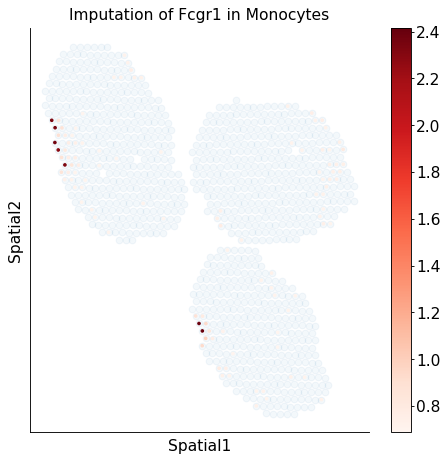

In [111]:
plt.figure(figsize=(6, 6))

name_ct = "Monocytes"
gene_name = ["Fcgr1"]


# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[gene_name], 1)
imp_ge = np.log(1 + 1e4 * imp_ge)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=5, cmap="Reds")
plt.colorbar()
plt.title(f"Imputation of {gene_name[0]} in {name_ct}")
prettify_axis(plt.gca())
plt.xticks([])
plt.yticks([])
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")
plt.tight_layout()
plt.savefig("figures/Monocytes_FCGR1.pdf")